<a href="https://colab.research.google.com/github/arch8080/Classification-of-Stars-Galaxies-and-Quasar/blob/main/Stellar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets
!pip install pandas
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: arch2212
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17


100%|██████████| 6.89M/6.89M [00:00<00:00, 9.71MB/s]


In [6]:
!pip install pandas numpy scikit-learn xgboost lightgbm optuna

In [7]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [10]:
df = pd.read_csv('/content/stellar-classification-dataset-sdss17/star_classification.csv')

In [11]:
df.head()


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [6]:
df.shape

(100000, 18)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [13]:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


In [14]:
df.isnull().sum()

,0
obj_ID,0
alpha,0
delta,0
u,0
g,0
r,0
i,0
z,0
run_ID,0
rerun_ID,0


In [18]:
df["class"].value_counts()

,count
class,
GALAXY,59445
STAR,21594
QSO,18961


In [20]:
df = df.dropna()

In [21]:
features = ['u', 'r', 'redshift', 'alpha', 'delta', 'plate']
X = df[features]
y = df['class']

In [22]:
y = y.astype("category").cat.codes

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"),
    "LightGBM": LGBMClassifier()
}

# Store results
results = {}

# Train & Evaluate Models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    results[name] = accuracy  # Store accuracy

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))  # Optional

# Convert results to DataFrame
df_results = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
print("\nModel Performance:\n", df_results)


Logistic Regression Accuracy: 0.9471
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     11860
           1       0.96      0.83      0.89      3797
           2       0.94      1.00      0.97      4343

    accuracy                           0.95     20000
   macro avg       0.95      0.93      0.94     20000
weighted avg       0.95      0.95      0.95     20000

Decision Tree Accuracy: 0.9605
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     11860
           1       0.90      0.90      0.90      3797
           2       1.00      1.00      1.00      4343

    accuracy                           0.96     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.96      0.96      0.96     20000

Random Forest Accuracy: 0.9762
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11860
           1       0.96      0

In [27]:
#OPTUNA Hyperparameter Tuning for XGBoost
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }

    model = XGBClassifier(**param, use_label_encoder=False, eval_metric="mlogloss")
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy").mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best Hyperparameters for XGBoost:", study.best_params)

# Train XGBoost with Best Params
best_xgb = XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric="mlogloss")
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
print("XGBoost Optimized Accuracy:", accuracy_score(y_test, y_pred))

[I 2025-03-18 11:05:37,473] A new study created in memory with name: no-name-5e569b17-4769-4515-bcbb-5ede0b32b01b
[I 2025-03-18 11:06:47,370] Trial 0 finished with value: 0.9723499999999999 and parameters: {'n_estimators': 478, 'max_depth': 9, 'learning_rate': 0.16308209763106488, 'subsample': 0.5156398697959022, 'colsample_bytree': 0.7405217999645163}. Best is trial 0 with value: 0.9723499999999999.
[I 2025-03-18 11:06:52,511] Trial 1 finished with value: 0.9730375 and parameters: {'n_estimators': 61, 'max_depth': 6, 'learning_rate': 0.2712231217598086, 'subsample': 0.9322205686562656, 'colsample_bytree': 0.5950873073278471}. Best is trial 1 with value: 0.9730375.
[I 2025-03-18 11:07:00,750] Trial 2 finished with value: 0.9713375000000001 and parameters: {'n_estimators': 91, 'max_depth': 5, 'learning_rate': 0.05902966676142942, 'subsample': 0.8953815398815674, 'colsample_bytree': 0.7249700530566335}. Best is trial 1 with value: 0.9730375.
[I 2025-03-18 11:07:36,983] Trial 3 finished w

Best Hyperparameters for XGBoost: {'n_estimators': 327, 'max_depth': 10, 'learning_rate': 0.015410011131206963, 'subsample': 0.8402422936111726, 'colsample_bytree': 0.9494841072005835}
XGBoost Optimized Accuracy: 0.9735



Stacking Model Accuracy: 0.9763
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11860
           1       0.96      0.92      0.94      3797
           2       1.00      1.00      1.00      4343

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



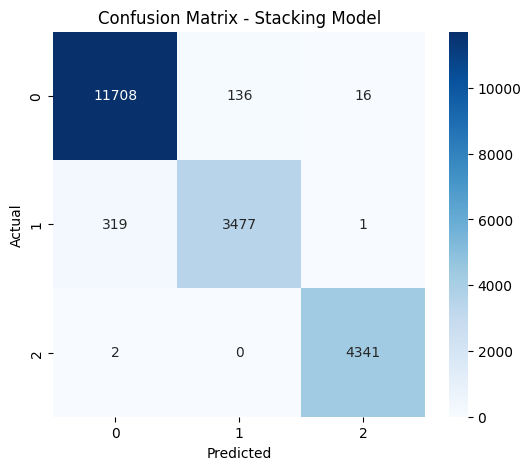

In [28]:
# Model Stacking (Combining Multiple Models)
stacking_model = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier()),
        ("svm", SVC(probability=True)),
        ("knn", KNeighborsClassifier()),
        ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")),
    ],
    final_estimator=LogisticRegression()
)

# Train Stacking Model
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)

# Evaluate Stacking Model
stacking_accuracy = accuracy_score(y_test, y_pred)
print(f"\nStacking Model Accuracy: {stacking_accuracy:.4f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix for Stacking Model
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix - Stacking Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

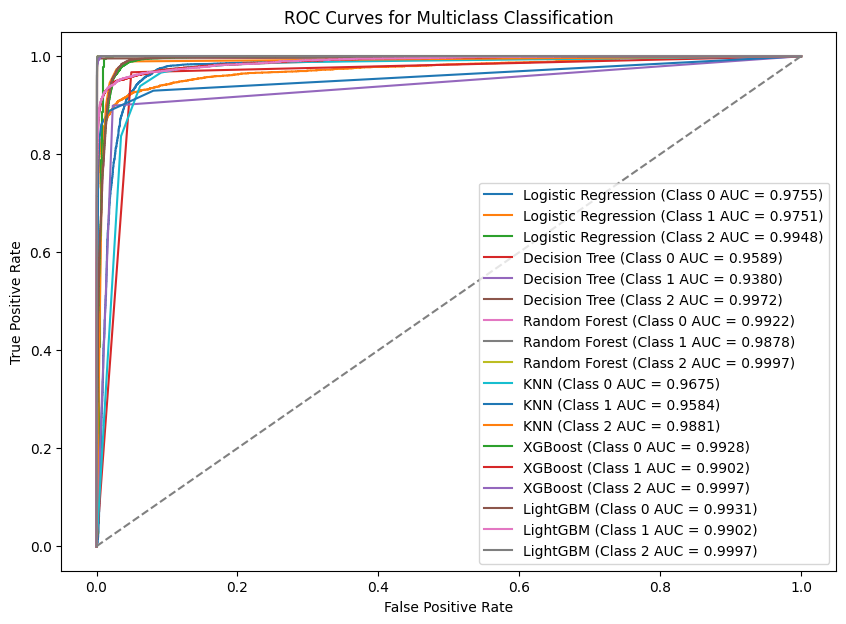

In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output (convert to one-vs-rest format)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 7))

for name, model in models.items():
    if hasattr(model, "predict_proba"):  # Check if model supports probability prediction
        y_score = model.predict_proba(X_test)
    else:
        continue  # Skip models that don’t support predict_proba

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (Class {i} AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multiclass Classification")
plt.legend()
plt.show()


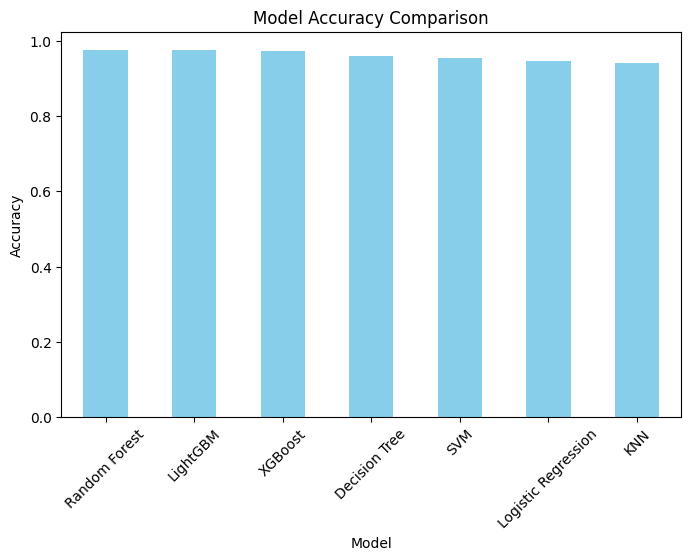

In [31]:
df_results.sort_values(by="Accuracy", ascending=False).plot(
    x="Model", y="Accuracy", kind="bar", color="skyblue", figsize=(8, 5), legend=False
)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.show()
